In [74]:
import torch

In [97]:
# Setup device-agnostic code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: mps


In [76]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset

class CurrentsDataset(Dataset):
    def __init__(self, transform=None):
        self.base_dir = "./processed-data/"

        self.currents = np.load(self.base_dir + "currents.npz", allow_pickle=True)['currents']
        self.transform = transform

        self.river_heights = np.load(self.base_dir + "river_heights.npz", allow_pickle=True)['river_heights']
        self.river_heights = (self.river_heights - np.nanmin(self.river_heights)) / (
        np.nanmax(self.river_heights) - np.nanmin(self.river_heights) # TO DO: make this part of the transforms
)

    def __len__(self):
        return len(self.currents)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.currents[idx]), self.transform(self.river_heights[idx])

        return self.currents[idx], self.river_heights[idx]

In [77]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.nan_to_num(torch.tensor(x, dtype=torch.float32), nan=0.0)),
])

In [78]:
dataset = CurrentsDataset(transform=transform)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_dataset = Subset(dataset, range(0, train_size))
test_dataset = Subset(dataset, range(train_size, len(dataset)))

BATCH_SIZE = 64

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False
)


In [84]:
current, label = next(iter(train_loader))
current.shape, label.shape

(torch.Size([64, 2, 74, 93]), torch.Size([64]))

In [85]:
current.dtype, label.dtype

(torch.float32, torch.float32)

In [80]:
import torch
import torch.nn as nn

class ConvRegressor(nn.Module):
    def __init__(self, input_channels=2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, stride=2, padding=1),  # [2,74,93] -> [16,37,47]
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [16,37,47] -> [32,19,24]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # [32,19,24] -> [64,10,12]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.flattened_size = 64 * 10 * 12

        self.regressor = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.regressor(x)
        return x

In [105]:
model = ConvRegressor()
model = model.to(device)
print(next(model.parameters()).device)


mps:0


In [106]:
from torchinfo import summary
summary(model, input_size=(1, 2, 74, 93))

Layer (type:depth-idx)                   Output Shape              Param #
ConvRegressor                            [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 10, 12]           --
│    └─Conv2d: 2-1                       [1, 16, 37, 47]           304
│    └─BatchNorm2d: 2-2                  [1, 16, 37, 47]           32
│    └─LeakyReLU: 2-3                    [1, 16, 37, 47]           --
│    └─Conv2d: 2-4                       [1, 32, 19, 24]           4,640
│    └─BatchNorm2d: 2-5                  [1, 32, 19, 24]           64
│    └─LeakyReLU: 2-6                    [1, 32, 19, 24]           --
│    └─Conv2d: 2-7                       [1, 64, 10, 12]           18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 10, 12]           128
│    └─LeakyReLU: 2-9                    [1, 64, 10, 12]           --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-10                      [1, 256]                  1,966,336

In [107]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
)

In [113]:
EPOCHS = 50

model = model.to(device)

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for currents, label in train_loader:
        currents = currents.to(device).float()
        label = label.to(device).float().unsqueeze(1)

        output = model(currents)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * currents.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for currents, labels in test_loader:
            currents = currents.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(currents)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * currents.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    scheduler.step(test_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.6f} | "
          f"Test Loss: {test_loss:.6f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch [1/50] | Train Loss: 0.000188 | Val Loss: 0.009869 | LR: 0.000031
Epoch [2/50] | Train Loss: 0.000175 | Val Loss: 0.009885 | LR: 0.000031
Epoch [3/50] | Train Loss: 0.000164 | Val Loss: 0.009898 | LR: 0.000031
Epoch [4/50] | Train Loss: 0.000154 | Val Loss: 0.009910 | LR: 0.000031
Epoch [5/50] | Train Loss: 0.000145 | Val Loss: 0.009922 | LR: 0.000016
Epoch [6/50] | Train Loss: 0.000143 | Val Loss: 0.009894 | LR: 0.000016
Epoch [7/50] | Train Loss: 0.000138 | Val Loss: 0.009911 | LR: 0.000016
Epoch [8/50] | Train Loss: 0.000133 | Val Loss: 0.009932 | LR: 0.000016
Epoch [9/50] | Train Loss: 0.000128 | Val Loss: 0.009951 | LR: 0.000016
Epoch [10/50] | Train Loss: 0.000124 | Val Loss: 0.009967 | LR: 0.000016
Epoch [11/50] | Train Loss: 0.000119 | Val Loss: 0.009980 | LR: 0.000008
Epoch [12/50] | Train Loss: 0.000118 | Val Loss: 0.010003 | LR: 0.000008
Epoch [13/50] | Train Loss: 0.000116 | Val Loss: 0.010021 | LR: 0.000008
Epoch [14/50] | Train Loss: 0.000113 | Val Loss: 0.010033 | 

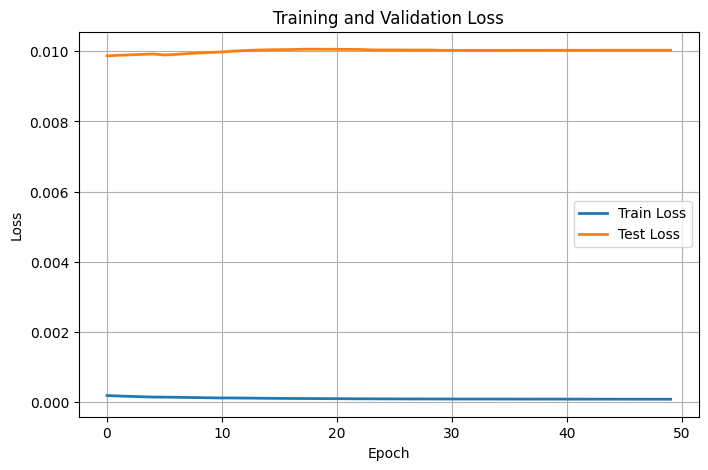

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()